# 05-sequence_logo.ipynb: Plot splice site motif frequencies
Helps generate the frequency of splice site motifs across genomic sequences. 

In [1]:
import pandas as pd

# read in coSI data generated through 01-splicing_efficiency.ipynb
cosi_long = pd.read_pickle("../data/processed_files/cosi_long.pkl.gz")

c3 = cosi_long[cosi_long.coSI=='$\\theta_3$'].copy()
c3["pos"] = c3["end"]+1

c5 = cosi_long[cosi_long.coSI=='$\\theta_5$'].copy()
c5["pos"] = c5["start"]

Create BED files for HBV splice sites

In [2]:
mc5 = c5[(c5["HBV_genotype"].str.contains("B|C"))].groupby("pos").max("Splicing efficiency")
mc5["start"] = mc5["start"]-10
mc5["end"] = mc5["end"]+18
mc5.to_csv("../data/processed_files/mc5.bed", sep="\t", header=None, index=None)

mc3 = c3[(c3["HBV_genotype"].str.contains("B|C"))].groupby("pos").max("Splicing efficiency")
mc3["start"] = mc3["start"]-20
mc3["end"] = mc3["end"]+8
mc3.to_csv("../data/processed_files/mc3.bed", sep="\t", header=None, index=None)

Get fasta sequences for HBV splice sites 

In [ ]:
# select genotypes B, C, and F, and recombinant forms (RF)
! awk 'BEGIN{RS=">"}NR>1{sub("\n","\t"); gsub("\n",""); print RS$0}' ../ref/hbvdb/pgrna/pgrna.fa \
    | awk '(/B.fa|C.fa|F.fa|RF.fa/) && (length($NF)==3240) {print $1 "|" $2, "\t" $NF}' \
    | sed 's/\.fa//' | awk '{print $1 "\n" $NF}' > ../data/processed_files/hbvdb_pgrna.fa

# get sequences and convert the format to BED
! grep ">" ../data/processed_files/hbvdb_pgrna.fa | sed 's/>//' \
    | while read i; do awk -v chrom=$i '{print chrom "\t" $0}' ../data/processed_files/mc5.bed; done \
    | bedtools getfasta -bed stdin -fi ../data/processed_files/hbvdb_pgrna.fa -tab -name \
    | sed 's/::/\t/;s/|/\t/3;s/:/\t/;s/-/\t/' \
    | awk 'BEGIN{OFS="\t"} {print $2,$4,$5,$3,$1,$NF}' > ../data/processed_files/hbvdb_pgrna_mc5.bed

! grep ">" ../data/processed_files/hbvdb_pgrna.fa | sed 's/>//' \
    | while read i; do awk -v chrom=$i '{print chrom "\t" $0}' ../data/processed_files/mc3.bed; done \
    | bedtools getfasta -bed stdin -fi ../data/processed_files/hbvdb_pgrna.fa -tab -name \
    | sed 's/::/\t/;s/|/\t/3;s/:/\t/;s/-/\t/' \
    | awk 'BEGIN{OFS="\t"} {print $2,$4,$5,$3,$1,$NF}' > ../data/processed_files/hbvdb_pgrna_mc3.bed

Plot sequence logos for HBV splice sites (Fig 6A--D)

In [ ]:
# randomly select overlaps for sliding windows
! SEED=123 && \
  MIN=1 && \
  MAX=12 && \
  \
  RANDOM=$SEED && \
  for i in {1..5}; do \
    RAND_NUM=$(( ( RANDOM % (MAX - MIN + 1) ) + MIN )) && \
    pyfasta split -k30 -n1 -o $RAND_NUM ../data/processed_files/hbvdb_pgrna.fa; done

! cat ../data/processed_files/hbvdb_pgrna.split.30mer.*overlap.fa > ../data/processed_files/hbvdb_pgrna.split.30mer.fa

# randomly sample 10% sequences
SEQS=`grep -c ">" ../data/processed_files/hbvdb_pgrna.split.30mer.fa | awk '{print int(($1*0.01)+0.5)}'`
! pyfastx sample -n ${SEQS} -s 42 --sequential-read -o ../data/processed_files/hbvdb_pgrna.split.30mer.10perc.fa  ../data/processed_files/hbvdb_pgrna.split.30mer.fa

# separate higher usage splice sites from lower usage and get fasta sequences
! awk '$5>=0.1 {print ">" $1 "\n" $NF}' ../data/processed_files/hbvdb_pgrna_mc5.bed > ../data/processed_files/hbvdb_pgrna_mc5_high.fa
! awk '$5<0.1 {print ">" $1 "\n" $NF}' ../data/processed_files/hbvdb_pgrna_mc5.bed > ../data/processed_files/hbvdb_pgrna_mc5_low.fa

! awk '$5>=0.1 {print ">" $1 "\n" $NF}' ../data/processed_files/hbvdb_pgrna_mc3.bed > ../data/processed_files/hbvdb_pgrna_mc3_high.fa
! awk '$5<0.1 {print ">" $1 "\n" $NF}' ../data/processed_files/hbvdb_pgrna_mc3.bed > ../data/processed_files/hbvdb_pgrna_mc3_low.fa

# plot logo
! for i in ../data/processed_files/hbvdb_pgrna_mc*fa; do \
    mkdir -p ${i%.*} && \
    kpLogo $i -bgfile ../data/processed_files/hbvdb_pgrna.split.30mer.10perc.fa -o ${i%.*}/kpLogo; done

Create BED files for human CDS splice sites

In [ ]:
# Filter out splice sites in the UTRs
bedtools intersect -a ../data/processed_files/ss.bed -b <(bed12ToBed6 -i ../ref/gencode.v41lift37.annotation.bed) -wo -s \
    | bedtools intersect -a stdin -b ../ref/utr.hs.bed -v \
    | cut -f-6 | awk '!seen[$0]++' \
    | bedtools intersect -a stdin -b <(awk 'BEGIN{OFS="\t"} {print $1,$2+1,$3,$4,$5,$6}' ../data/huh7/intron.zeta.pUC57.bed) -wo \
    | awk 'BEGIN{OFS="\t"} ($2==$8) && /donor/ {print $1,$2-10,$3+18,$5 "|" $11,$4,$6}' \
    | bedtools getfasta -bed stdin -fi ../ref/hg19.fa -tab -name -s \
    | sed 's/::/\t/;s/|/\t/;s/:/\t/;s/-/\t/;s/(/\t/;s/)//' \
    | awk 'BEGIN{OFS="\t"} {print $3,$4,$5,$1,$2,$6,toupper($NF)}' \
    | sort -u > ../data/processed_files/exonicss_mc5.bed

bedtools intersect -a ../data/processed_files/ss.bed -b <(bed12ToBed6 -i ../ref/gencode.v41lift37.annotation.bed) -wo -s \
    | bedtools intersect -a stdin -b ../ref/utr.hs.bed -v \
    | cut -f-6 | awk '!seen[$0]++' \
    | bedtools intersect -a stdin -b <(awk 'BEGIN{OFS="\t"} {print $1,$2,$3-1,$4,$5,$6}' ../data/huh7/intron.zeta.pUC57.bed) -wo \
    | awk 'BEGIN{OFS="\t"} ($3==$9) && /acceptor/ {print $1,$2-20,$3+8,$5 "|" $11,$4,$6}' \
    | bedtools getfasta -bed stdin -fi ../ref/hg19.fa -tab -name -s \
    | sed 's/::/\t/;s/|/\t/;s/:/\t/;s/-/\t/;s/(/\t/;s/)//' \
    | awk 'BEGIN{OFS="\t"} {print $3,$4,$5,$1,$2,$6,toupper($NF)}' \
    | sort -u > ../data/processed_files/exonicss_mc3.bed

# get genes with CDS splice sites
cat ../data/processed_files/exonicss_mc*.bed \
    | cut -f4 | sort -u \
    | join -1 1 -2 12 -o 2.1,2.2,2.3,2.4,2.5,2.6,2.7,2.8,2.9,2.10,2.11,2.12,2.13,2.14,2.15 -t$'\t' - \
    <(zcat ../ref/gencode.v41lift37.annotation.genepred.txt.gz | sort -k12,12) \
    | genePredToBed stdin stdout \
    | bedtools getfasta -bed stdin -fi ../ref/hg19.fa -split -name -s > ../data/processed_files/exonicss_genes.fa

Plot sequence logos for human CDS splice sites (Fig 6E and F)

In [ ]:
# randomly select overlaps for sliding windows
! SEED=123 && \
  MIN=1 && \
  MAX=12 && \
  \
  RANDOM=$SEED && \
  for i in {1..5}; do \
    RAND_NUM=$(( ( RANDOM % (MAX - MIN + 1) ) + MIN )) && \
    pyfasta split -k30 -n1 -o $RAND_NUM ../data/processed_files/exonicss_genes.fa; done
    
! cat ../data/processed_files/exonicss_genes.split.30mer.*overlap.fa > ../data/processed_files/exonicss_genes.split.30mer.fa

# randomly sample 1% sequences
SEQS=`grep -c ">" ../data/processed_files/exonicss_genes.split.30mer.fa | awk '{print int(($1*0.01)+0.5)}'`
! pyfastx sample -n ${SEQS} -s 42 --sequential-read -o ../data/processed_files/exonicss_genes.split.30mer.1perc.fa  ../data/processed_files/exonicss_genes.split.30mer.fa

# get fasta sequences
! awk '{print ">" $1 "\n" $NF}' ../data/processed_files/exonicss_mc5.bed > ../data/processed_files/exonicss_mc5.fa
! awk '{print ">" $1 "\n" $NF}' ../data/processed_files/exonicss_mc3.bed > ../data/processed_files/exonicss_mc3.fa

# plot logo
! for i in ../data/processed_files/exonicss_mc*fa; do \
    mkdir -p ${i%.*} && \
    kpLogo $i -bgfile ../data/processed_files/exonicss_genes.split.30mer.1perc.fa -o ${i%.*}/kpLogo; done

Create BED files for human typical splice sites

In [ ]:
! bedtools intersect -a ../data/processed_files/ss.bed -b <(awk 'BEGIN{OFS="\t"} {print $1,$2+1,$3,$4,$5,$6}' ../data/huh7/intron.zeta.pUC57.bed) -wo \
    | awk 'BEGIN{OFS="\t"} ($2==$8) && /donor/ {print $1,$2-10,$3+18,$5 "|" $11,$4,$6}' \
    | bedtools getfasta -bed stdin -fi ../ref/hg19.fa -tab -name -s \
    | sed 's/::/\t/;s/|/\t/;s/:/\t/;s/-/\t/;s/(/\t/;s/)//' \
    | awk 'BEGIN{OFS="\t"} {print $3,$4,$5,$1,$2,$6,toupper($NF)}' \
    | sort -u > ../data/processed_files/hg19_mc5.bed
# exclude CDS splice donor sites
! comm -23 <(sort ../data/processed_files/hg19_mc5.bed) <(sort ../data/processed_files/exonicss_mc5.bed) > ../data/processed_files/hg19_mc5.bed2
! mv ../data/processed_files/hg19_mc5.bed2 ../data/processed_files/hg19_mc5.bed

! bedtools intersect -a ../data/processed_files/ss.bed -b <(awk 'BEGIN{OFS="\t"} {print $1,$2,$3-1,$4,$5,$6}' ../data/huh7/intron.zeta.pUC57.bed) -wo \
    | awk 'BEGIN{OFS="\t"} ($3==$9) && /acceptor/ {print $1,$2-20,$3+8,$5 "|" $11,$4,$6}' \
    | bedtools getfasta -bed stdin -fi ../ref/hg19.fa -tab -name -s \
    | sed 's/::/\t/;s/|/\t/;s/:/\t/;s/-/\t/;s/(/\t/;s/)//' \
    | awk 'BEGIN{OFS="\t"} {print $3,$4,$5,$1,$2,$6,toupper($NF)}' \
    | sort -u > ../data/processed_files/hg19_mc3.bed
# exclude CDS splice acceptor sites
! comm -23 <(sort ../data/processed_files/hg19_mc3.bed) <(sort ../data/processed_files/exonicss_mc3.bed) > ../data/processed_files/hg19_mc3.bed2
! mv ../data/processed_files/hg19_mc3.bed2 ../data/processed_files/hg19_mc3.bed

# get genes with typical splice sites
! cat ../data/processed_files/hg19_mc*.bed \
    | cut -f4 | sort -u \
    | join -1 1 -2 12 -o 2.1,2.2,2.3,2.4,2.5,2.6,2.7,2.8,2.9,2.10,2.11,2.12,2.13,2.14,2.15 -t$'\t' - \
    <(zcat ../ref/gencode.v41lift37.annotation.genepred.txt.gz | sort -k12,12) \
    | genePredToBed stdin stdout \
    | bedtools getfasta -bed stdin -fi ../ref/hg19.fa -split -name -s > ../ref/hg19_genes.fa

Plot sequence logos for human typical splice sites (Supplementary Fig S4)

In [ ]:
# randomly select overlaps for sliding windows
! SEED=123 && \
  MIN=1 && \
  MAX=12 && \
  \
  RANDOM=$SEED && \
  for i in {1..5}; do \
    RAND_NUM=$(( ( RANDOM % (MAX - MIN + 1) ) + MIN )) && \
    pyfasta split -k30 -n1 -o $RAND_NUM ../data/processed_files/hg19_genes.fa; done
    
! cat ../data/processed_files/hg19_genes.split.30mer.*overlap.fa > ../data/processed_files/hg19_genes.split.30mer.fa

# randomly sample 1% sequences
SEQS=`grep -c ">" ../data/processed_files/hg19_genes.split.30mer.fa | awk '{print int(($1*0.01)+0.5)}'`
! pyfastx sample -n ${SEQS} -s 42 --sequential-read -o ../data/processed_files/hg19_genes.split.30mer.1perc.fa  ../data/processed_files/hg19_genes.split.30mer.fa

# get fasta sequences
! awk '{print ">" $1 "\n" $NF}' ../data/processed_files/hg19_mc5.bed > ../data/processed_files/hg19_mc5.fa
! awk '{print ">" $1 "\n" $NF}' ../data/processed_files/hg19_mc3.bed > ../data/processed_files/hg19_mc3.fa

# plot logo
! for i in ../data/processed_files/hg19_mc*fa; do \
    mkdir -p ${i%.*} && \
    kpLogo $i -bgfile ../data/processed_files/hg19_genes.split.30mer.1perc.fa -o ${i%.*}/kpLogo; done

##### Create Position Weight Matrices (PWMs) and compare host and HBV PWMs using Tomtom

In [1]:
from Bio import motifs
from Bio import SeqIO

from memelite import tomtom
from memelite.io import read_meme
from memelite.utils import one_hot_encode

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import wilcoxon, mannwhitneyu

Host's CDS vs typical splice sites (as controls)

In [2]:
# Load host typical splice site sequences
host_sequences = [record.seq for record in SeqIO.parse("../data/processed_files/hg19_mc5.fa", "fasta")]
motif_host = motifs.create(host_sequences)
pwm_array_host = np.array([motif_host.counts[n] for n in "ACGT"])
pwm_array_host = pwm_array_host / pwm_array_host.sum(axis=0)

exonicss_mc5 = pd.read_csv("../data/processed_files/exonicss_mc5.bed", sep="\t", header=None)
exonicss_mc5 = exonicss_mc5[exonicss_mc5[6].apply(lambda x: all(c in "ACGT" for c in x))].copy()

q = [one_hot_encode(seq) for seq in exonicss_mc5[6]]
p_values, scores, offsets, overlaps, strands = tomtom(q, [pwm_array_host], reverse_complement=False)
exonicss_mc5["pvalue"] = p_values[:, 0]
exonicss_mc5["score"] = scores[:, 0]
exonicss_mc5["query"] = "CDS"
exonicss_mc5.columns = ["chr","start","end","gene_id","coSI","strand","seq","pvalue","score","query"]


# Load host CDS splice site sequences
cds_sequences = [record.seq for record in SeqIO.parse("../data/processed_files/exonicss_mc5.fa", "fasta")]
motif_cds = motifs.create(cds_sequences)
pwm_array_cds = np.array([motif_cds.counts[n] for n in "ACGT"])
pwm_array_cds = pwm_array_cds / pwm_array_cds.sum(axis=0)

hg19_mc5 = pd.read_csv("../data/processed_files/hg19_mc5.bed", sep="\t", header=None)
hg19_mc5 = hg19_mc5[hg19_mc5[6].apply(lambda x: all(c in "ACGT" for c in x))].copy()

q = [one_hot_encode(seq) for seq in hg19_mc5[6]]
p_values, scores, offsets, overlaps, strands = tomtom(q, [pwm_array_cds], reverse_complement=False)
hg19_mc5["pvalue"] = p_values[:, 0]
hg19_mc5["score"] = scores[:, 0]
hg19_mc5["query"] = "Typical"
hg19_mc5.columns = ["chr","start","end","gene_id","coSI","strand","seq","pvalue","score","query"]


mc5 = pd.concat([exonicss_mc5, hg19_mc5])
mc5.to_pickle("../data/processed_files/mc5.pkl.gz")

In [2]:
# Load host typical splice site sequences
host_sequences = [record.seq for record in SeqIO.parse("../data/processed_files/hg19_mc3.fa", "fasta")]
motif_host = motifs.create(host_sequences)
pwm_array_host = np.array([motif_host.counts[n] for n in "ACGT"])
pwm_array_host = pwm_array_host / pwm_array_host.sum(axis=0)

exonicss_mc3 = pd.read_csv("../data/processed_files/exonicss_mc3.bed", sep="\t", header=None)
exonicss_mc3 = exonicss_mc3[exonicss_mc3[6].apply(lambda x: all(c in "ACGT" for c in x))].copy()

q = [one_hot_encode(seq) for seq in exonicss_mc3[6]]
p_values, scores, offsets, overlaps, strands = tomtom(q, [pwm_array_host], reverse_complement=False)
exonicss_mc3["pvalue"] = p_values[:, 0]
exonicss_mc3["score"] = scores[:, 0]
exonicss_mc3["query"] = "CDS"
exonicss_mc3.columns = ["chr","start","end","gene_id","coSI","strand","seq","pvalue","score","query"]


# Load host CDS splice site sequences
cds_sequences = [record.seq for record in SeqIO.parse("../data/processed_files/exonicss_mc3.fa", "fasta")]
motif_cds = motifs.create(cds_sequences)
pwm_array_cds = np.array([motif_cds.counts[n] for n in "ACGT"])
pwm_array_cds = pwm_array_cds / pwm_array_cds.sum(axis=0)

hg19_mc3 = pd.read_csv("../data/processed_files/hg19_mc3.bed", sep="\t", header=None)
hg19_mc3 = hg19_mc3[hg19_mc3[6].apply(lambda x: all(c in "ACGT" for c in x))].copy()

q = [one_hot_encode(seq) for seq in hg19_mc3[6]]
p_values, scores, offsets, overlaps, strands = tomtom(q, [pwm_array_cds], reverse_complement=False)
hg19_mc3["pvalue"] = p_values[:, 0]
hg19_mc3["score"] = scores[:, 0]
hg19_mc3["query"] = "Typical"
hg19_mc3.columns = ["chr","start","end","gene_id","coSI","strand","seq","pvalue","score","query"]


mc3 = pd.concat([exonicss_mc3, hg19_mc3])
mc3.to_pickle("../data/processed_files/mc3.pkl.gz")

In [3]:
mc5 = pd.read_pickle("../data/processed_files/mc5.pkl.gz")
mc3 = pd.read_pickle("../data/processed_files/mc3.pkl.gz")

mc5["neg_log_p"] =  -np.log10(mc5["pvalue"])
mc3["neg_log_p"] =  -np.log10(mc3["pvalue"])

mc5["Splice site"] = "Donor site"
mc3["Splice site"] = "Acceptor site"

hg19_control = pd.concat([mc5, mc3])

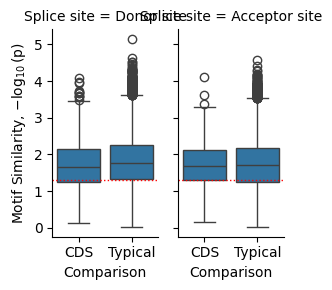

In [4]:
g = sns.FacetGrid(hg19_control, col="Splice site", height=3, aspect=.5)
g.map(sns.boxplot, "query", "neg_log_p", order=["CDS","Typical"])
g.set_axis_labels("Comparison", r"Motif Similarity, $-\log_{10}$(p)") 

threshold = -np.log10(0.05)
for ax in g.axes.flat:
    ax.axhline(y=threshold, color="red", linestyle=":", linewidth=1)

plt.savefig("../results/figures/fig6/usage_comparison_hg19_control.pdf", bbox_inches='tight')

In [5]:
cds_vals = mc5[mc5["query"]=="CDS"].neg_log_p
typical_vals = mc5[mc5["query"]=="Typical"].neg_log_p

stat, p_mwu = mannwhitneyu(cds_vals, typical_vals, alternative='two-sided')

n1, n2 = len(cds_vals), len(typical_vals)
r_effect_size = (2 * stat / (n1 * n2)) - 1

print(f"Mann–Whitney U test: U = {stat}, p-value = {p_mwu}")
print(f"Effect size (rank-biserial correlation): {r_effect_size}")

Mann–Whitney U test: U = 24495705.0, p-value = 5.012541968870828e-07
Effect size (rank-biserial correlation): -0.08348419833048137


In [6]:
cds_vals = mc3[mc3["query"]=="CDS"].neg_log_p
typical_vals = mc3[mc3["query"]=="Typical"].neg_log_p

stat, p_mwu = mannwhitneyu(cds_vals, typical_vals, alternative='two-sided')

n1, n2 = len(cds_vals), len(typical_vals)
r_effect_size = (2 * stat / (n1 * n2)) - 1

print(f"Mann–Whitney U test: U = {stat}, p-value = {p_mwu}")
print(f"Effect size (rank-biserial correlation): {r_effect_size}")

Mann–Whitney U test: U = 15291531.0, p-value = 0.9369535855322754
Effect size (rank-biserial correlation): -0.0018090318295080898


HBV vs host 5' splice sites

In [2]:
# Load host typical splice site sequences
host_sequences = [record.seq for record in SeqIO.parse("../data/processed_files/hg19_mc5.fa", "fasta")]
motif_host = motifs.create(host_sequences)
pwm_array_host = np.array([motif_host.counts[n] for n in "ACGT"])
pwm_array_host = pwm_array_host / pwm_array_host.sum(axis=0)

# Load host CDS splice site sequences
cds_sequences = [record.seq for record in SeqIO.parse("../data/processed_files/exonicss_mc5.fa", "fasta")]
motif_cds = motifs.create(cds_sequences)
pwm_array_cds = np.array([motif_cds.counts[n] for n in "ACGT"])
pwm_array_cds = pwm_array_cds / pwm_array_cds.sum(axis=0)

hbvdb_pgrna_mc5 = pd.read_csv("../data/processed_files/hbvdb_pgrna_mc5.bed", sep="\t", header=None)
hbvdb_pgrna_mc5 = hbvdb_pgrna_mc5[hbvdb_pgrna_mc5[5].apply(lambda x: all(c in "ACGT" for c in x))].copy()

q = [one_hot_encode(seq) for seq in hbvdb_pgrna_mc5[5]]
p_values, scores, offsets, overlaps, strands = tomtom(q, [pwm_array_host], reverse_complement=False)
hbvdb_pgrna_mc5["pvalue_typical"] = p_values[:, 0]
hbvdb_pgrna_mc5["score_typical"] = scores[:, 0]

p_values, scores, offsets, overlaps, strands = tomtom(q, [pwm_array_cds], reverse_complement=False)
hbvdb_pgrna_mc5["pvalue_cds"] = p_values[:, 0]
hbvdb_pgrna_mc5["score_cds"] = scores[:, 0]

hbvdb_pgrna_mc5.columns = ["id","start","end","genotype","coSI","seq","pvalue_typical","score_typical","pvalue_cds","score_cds"]
hbvdb_pgrna_mc5.to_pickle("../data/processed_files/hbvdb_pgrna_mc5.pkl.gz")

In [3]:
hbvdb_pgrna_mc5 = pd.read_pickle("../data/processed_files/hbvdb_pgrna_mc5.pkl.gz")

long_df = hbvdb_pgrna_mc5.melt(
    id_vars=['id', 'start', 'end', 'genotype', 'coSI', 'seq'],
    value_vars=['pvalue_typical', 'pvalue_cds'],
    var_name='comparison',
    value_name='pvalue'
)
long_df['comparison'] = long_df['comparison'].str.replace('pvalue_', '')
long_df['Usage'] = np.where(long_df['coSI'] < 0.1, 'low', 'high')
long_df = long_df.sort_values("genotype")
long_df["neg_log_p"] =  -np.log10(long_df["pvalue"])

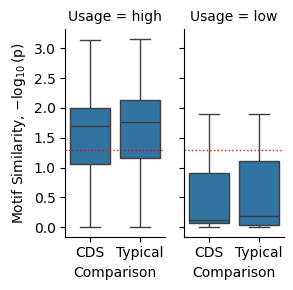

In [4]:
g = sns.FacetGrid(long_df.sort_values("Usage"), col="Usage", height=3, aspect=.5)
g.map(sns.boxplot, "comparison", "neg_log_p", order=["cds","typical"])
g.set_axis_labels("Comparison", r"Motif Similarity, $-\log_{10}$(p)") 

new_labels = ["CDS","Typical"]
tick_positions = np.arange(len(new_labels))

for ax in g.axes.flat:
    # Set the locations of the ticks
    ax.set_xticks(tick_positions)
    # Set the new labels for the x-ticks
    ax.set_xticklabels(new_labels)

threshold = -np.log10(0.05)
for ax in g.axes.flat:
    ax.axhline(y=threshold, color="red", linestyle=":", linewidth=1)
    
plt.savefig("../results/figures/fig6/usage_comparison_mc5.pdf", bbox_inches='tight')

In [5]:
high_vals = long_df[(long_df['Usage'] == 'high') & (long_df['comparison'] == 'cds')]['neg_log_p']
low_vals = long_df[(long_df['Usage'] == 'low') & (long_df['comparison'] == 'cds')]['neg_log_p']

stat, p_mwu = mannwhitneyu(high_vals, low_vals, alternative='two-sided')

n1, n2 = len(high_vals), len(low_vals)
r_effect_size = (2 * stat / (n1 * n2)) - 1

print(f"Mann–Whitney U test: U = {stat}, p-value = {p_mwu}")
print(f"Effect size (rank-biserial correlation): {r_effect_size}")

Mann–Whitney U test: U = 312120495.0, p-value = 0.0
Effect size (rank-biserial correlation): 0.7920239455633458


In [6]:
high_df = long_df[long_df['Usage'] == "high"]
stat, p_wilcoxon = wilcoxon(high_df[high_df.comparison=="cds"].neg_log_p, high_df[high_df.comparison=="typical"].neg_log_p)

# Compute Z manually
n = len(high_df) / 2
mean_rank_sum = n * (n + 1) / 4
sd_rank_sum = np.sqrt(n * (n + 1) * (2*n + 1) / 24)
z = (stat - mean_rank_sum) / sd_rank_sum

r_effect_size = abs(z) / np.sqrt(n)

median_cds = high_df[high_df.comparison=="cds"].neg_log_p.median()
median_typical = high_df[high_df.comparison=="typical"].neg_log_p.median()

print(f"Wilcoxon signed-rank test: statistic = {stat}, p-value = {p_wilcoxon}")
print(f"Z = {z}, r = {r_effect_size}")
print(f"CDS median = {median_cds}, typical median = {median_typical}")

Wilcoxon signed-rank test: statistic = 75582552.0, p-value = 6.1413002127462935e-53
Z = -15.314037549908095, r = 0.11217946300911247
CDS median = 1.6930629216435373, typical median = 1.7661953136868038


In [7]:
low_df = long_df[long_df['Usage'] == "low"]
stat, p_wilcoxon = wilcoxon(low_df[low_df.comparison=="cds"].neg_log_p, low_df[low_df.comparison=="typical"].neg_log_p)

# Compute Z manually
n = len(low_df) / 2
mean_rank_sum = n * (n + 1) / 4
sd_rank_sum = np.sqrt(n * (n + 1) * (2*n + 1) / 24)
z = (stat - mean_rank_sum) / sd_rank_sum

r_effect_size = abs(z) / np.sqrt(n)

median_cds = low_df[low_df.comparison=="cds"].neg_log_p.median()
median_typical = low_df[low_df.comparison=="typical"].neg_log_p.median()

print(f"Z = {z}, r = {r_effect_size}")
print(f"Wilcoxon signed-rank test: statistic = {stat}, p-value = {p_wilcoxon}")
print(f"CDS median = {median_cds}, typical median = {median_typical}")

Z = -2.5472377133893755, r = 0.018631232691723787
Wilcoxon signed-rank test: statistic = 85473159.0, p-value = 0.010853751761212397
CDS median = 0.11894722765421618, typical median = 0.18351205672189935


HBV vs host 3' splice sites

In [2]:
# Load host typical splice site sequences
host_sequences = [record.seq for record in SeqIO.parse("../data/processed_files/hg19_mc3.fa", "fasta")]
motif_host = motifs.create(host_sequences)
pwm_array_host = np.array([motif_host.counts[n] for n in "ACGT"])
pwm_array_host = pwm_array_host / pwm_array_host.sum(axis=0)

# Load host CDS splice site sequences
cds_sequences = [record.seq for record in SeqIO.parse("../data/processed_files/exonicss_mc3.fa", "fasta")]
motif_cds = motifs.create(cds_sequences)
pwm_array_cds = np.array([motif_cds.counts[n] for n in "ACGT"])
pwm_array_cds = pwm_array_cds / pwm_array_cds.sum(axis=0)

hbvdb_pgrna_mc3 = pd.read_csv("../data/processed_files/hbvdb_pgrna_mc3.bed", sep="\t", header=None)
# hbvdb_pgrna_mc3[hbvdb_pgrna_mc3[5].str.contains(r"AG........$")]
hbvdb_pgrna_mc3 = hbvdb_pgrna_mc3[hbvdb_pgrna_mc3[5].apply(lambda x: all(c in "ACGT" for c in x))].copy()

q = [one_hot_encode(seq) for seq in hbvdb_pgrna_mc3[5]]
p_values, scores, offsets, overlaps, strands = tomtom(q, [pwm_array_host], reverse_complement=False)
hbvdb_pgrna_mc3["pvalue_typical"] = p_values[:, 0]
hbvdb_pgrna_mc3["score_typical"] = scores[:, 0]

p_values, scores, offsets, overlaps, strands = tomtom(q, [pwm_array_cds], reverse_complement=False)
hbvdb_pgrna_mc3["pvalue_cds"] = p_values[:, 0]
hbvdb_pgrna_mc3["score_cds"] = scores[:, 0]

hbvdb_pgrna_mc3.columns = ["id","start","end","genotype","coSI","seq","pvalue_typical","score_typical","pvalue_cds","score_cds"]
hbvdb_pgrna_mc3.to_pickle("../data/processed_files/hbvdb_pgrna_mc3.pkl.gz")

In [3]:
hbvdb_pgrna_mc3 = pd.read_pickle("../data/processed_files/hbvdb_pgrna_mc3.pkl.gz")

long_df = hbvdb_pgrna_mc3.melt(
    id_vars=['id', 'start', 'end', 'genotype', 'coSI', 'seq'],
    value_vars=['pvalue_typical', 'pvalue_cds'],
    var_name='comparison',
    value_name='pvalue'
)
long_df['comparison'] = long_df['comparison'].str.replace('pvalue_', '')
long_df['Usage'] = np.where(long_df['coSI'] < 0.1, 'low', 'high')
long_df = long_df.sort_values("genotype")
long_df["neg_log_p"] =  -np.log10(long_df["pvalue"])

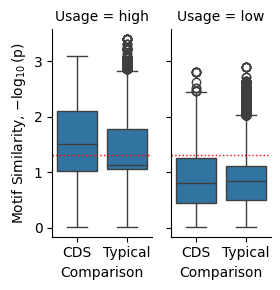

In [4]:
g = sns.FacetGrid(long_df.sort_values("Usage"), col="Usage", height=3, aspect=.5)
g.map(sns.boxplot, "comparison", "neg_log_p", order=["cds","typical"])
g.set_axis_labels("Comparison", r"Motif Similarity, $-\log_{10}$(p)") 

new_labels = ["CDS","Typical"]
tick_positions = np.arange(len(new_labels))

for ax in g.axes.flat:
    # Set the locations of the ticks
    ax.set_xticks(tick_positions)
    # Set the new labels for the x-ticks
    ax.set_xticklabels(new_labels)

threshold = -np.log10(0.05)
for ax in g.axes.flat:
    ax.axhline(y=threshold, color="red", linestyle=":", linewidth=1)
    
plt.savefig("../results/figures/fig6/usage_comparison_mc3.pdf", bbox_inches='tight')

In [5]:
high_vals = long_df[(long_df['Usage'] == 'high') & (long_df['comparison'] == 'cds')]['neg_log_p']
low_vals = long_df[(long_df['Usage'] == 'low') & (long_df['comparison'] == 'cds')]['neg_log_p']

stat, p_mwu = mannwhitneyu(high_vals, low_vals, alternative='two-sided')

n1, n2 = len(high_vals), len(low_vals)
r_effect_size = (2 * stat / (n1 * n2)) - 1

print(f"Mann–Whitney U test: U = {stat}, p-value = {p_mwu}")
print(f"Effect size (rank-biserial correlation): {r_effect_size}")

Mann–Whitney U test: U = 974667596.0, p-value = 0.0
Effect size (rank-biserial correlation): 0.6300927868891106


In [6]:
high_df = long_df[long_df['Usage'] == "high"]
stat, p_wilcoxon = wilcoxon(high_df[high_df.comparison=="cds"].neg_log_p, high_df[high_df.comparison=="typical"].neg_log_p)

# Compute Z manually
n = len(high_df) / 2
mean_rank_sum = n * (n + 1) / 4
sd_rank_sum = np.sqrt(n * (n + 1) * (2*n + 1) / 24)
z = (stat - mean_rank_sum) / sd_rank_sum

r_effect_size = abs(z) / np.sqrt(n)

median_cds = high_df[high_df.comparison=="cds"].neg_log_p.median()
median_typical = high_df[high_df.comparison=="typical"].neg_log_p.median()

print(f"Wilcoxon signed-rank test: statistic = {stat}, p-value = {p_wilcoxon}")
print(f"Z = {z}, r = {r_effect_size}")
print(f"CDS median = {median_cds}, typical median = {median_typical}")

Wilcoxon signed-rank test: statistic = 111197460.0, p-value = 1.117120117119224e-130
Z = -24.32297871877648, r = 0.15919488976222623
CDS median = 1.5145177889062507, typical median = 1.124700587381394


In [7]:
low_df = long_df[long_df['Usage'] == "low"]
stat, p_wilcoxon = wilcoxon(low_df[low_df.comparison=="cds"].neg_log_p, low_df[low_df.comparison=="typical"].neg_log_p)

# Compute Z manually
n = len(low_df) / 2
mean_rank_sum = n * (n + 1) / 4
sd_rank_sum = np.sqrt(n * (n + 1) * (2*n + 1) / 24)
z = (stat - mean_rank_sum) / sd_rank_sum

r_effect_size = abs(z) / np.sqrt(n)

median_cds = low_df[low_df.comparison=="cds"].neg_log_p.median()
median_typical = low_df[low_df.comparison=="typical"].neg_log_p.median()

print(f"Z = {z}, r = {r_effect_size}")
print(f"Wilcoxon signed-rank test: statistic = {stat}, p-value = {p_wilcoxon}")
print(f"CDS median = {median_cds}, typical median = {median_typical}")

Z = -22.612924940924184, r = 0.09990961366810597
Wilcoxon signed-rank test: statistic = 580377264.0, p-value = 3.2335159881729494e-113
CDS median = 0.8063292870930467, typical median = 0.8354805289825918
